# Face Recognition

In [150]:
import pandas as pd
import base64
import numpy as np
from PIL import Image
import io
import cv2 as cv2
from io import BytesIO
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as rand
from scipy import io as sp
import dlib
import os
import itertools as it
from sklearn.metrics import accuracy_score
import tensorflow as tf 
from sklearn.manifold import TSNE
colors = sns.color_palette()
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
from keras.layers import concatenate
from sklearn.metrics import precision_score
from sklearn.svm import NuSVC

# MAC OS specific setting
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [151]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [152]:
path = ""

In [153]:
clebs = pd.read_csv(path + 'images.csv', error_bad_lines=False)

### Sample Data

In [154]:
clebs.head()

,Image,Name
0,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
1,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
2,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
3,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
4,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon


### Data distribution

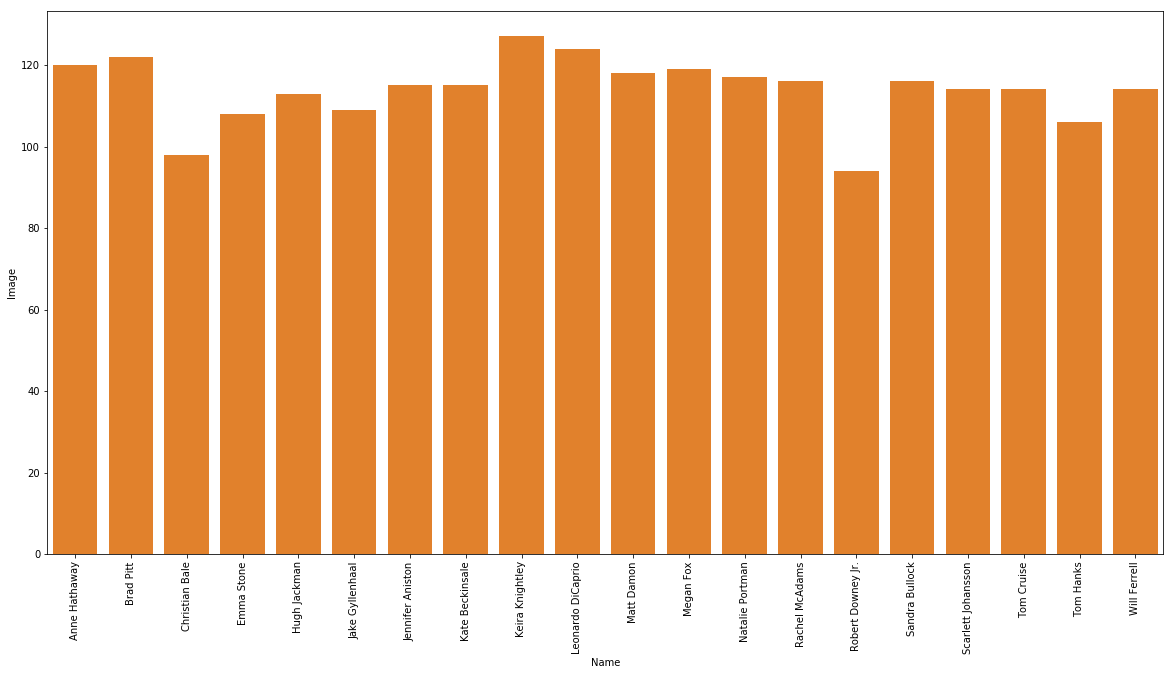

In [155]:
celebCount = clebs.groupby(['Name']).count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x='Name', y='Image', data=celebCount, color = colors[1])
plt.show()

### Utility functions to work around with Images

In [156]:
def get_image(base64Image, display=True):
    img = Image.open(BytesIO(base64.b64decode(base64Image))).convert('RGB') 
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
    return img
#   to open image in new window
#   img.show()

def get_opencv2_image(base64Image, display=False):
    return cv2.cvtColor(np.array(get_image(base64Image, display)), cv2.COLOR_RGB2BGR)

def convertToRGB(opencv2_image):
    return cv2.cvtColor(opencv2_image, cv2.COLOR_BGR2RGB)

def rect_to_cordinate(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

### Detect Faces in a image using the dlib frontal face detector

In [157]:
def detect_faces(test_image, display=True, scaleFactor = 1):
    face_detector = dlib.get_frontal_face_detector()
    faces_rect = face_detector(test_image, 1)
    
    if display:
        image_copy = test_image.copy()
        for rect in faces_rect:
            (x,y,w,h) = rect_to_cordinate(rect)
            cv2.rectangle(image_copy, (x,y), (x+w, y+h), (0,255,255), 2)
    
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(image_copy))
    
    return faces_rect

### Detect Landmarks on face using the dlib shape predictor

In [158]:
def detect_landmarks(image, faces, display=True):
    pose_landmarks = None
    face_pose_predictor = dlib.shape_predictor(path + "/shape_predictor_68_face_landmarks.dat")
    
    if display:
        test_copy = image.copy()
    
    for face in faces:
        pose_landmarks = face_pose_predictor(image, face)
        if display:
            for (x, y) in shape_to_np(pose_landmarks):
                cv2.circle(test_copy, (x, y), 1, (0,0,255), -1)
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(test_copy))
    
    return pose_landmarks

### Scale the image to 128x128 and fix posture 

In [159]:
def scale_face(image, landmarks, display=True):
    fod = dlib.full_object_detections()
    fod.append(landmarks)
    img = dlib.get_face_chips(image, fod, size=128)
    if display:
        for x in img:
            plt.figure(figsize=(8,8))
            plt.imshow(convertToRGB(x))
    return img

### Utililty function to get scaled postured image of 128x128 using the above functions

In [160]:
from skimage.color import rgb2gray
def get_scaled(base64image,display=False):
    img_raw = get_opencv2_image(base64image)
    faces = detect_faces(img_raw,display=False)
    if not faces:
        return np.nan
    landmarks = detect_landmarks(img_raw, faces,display=False)
    scaleimg = scale_face(img_raw, landmarks, display=display)
    return scaleimg[0]
def get_greyscale(image_numpy):
    return rgb2gray(image_numpy)

### Detect Faces

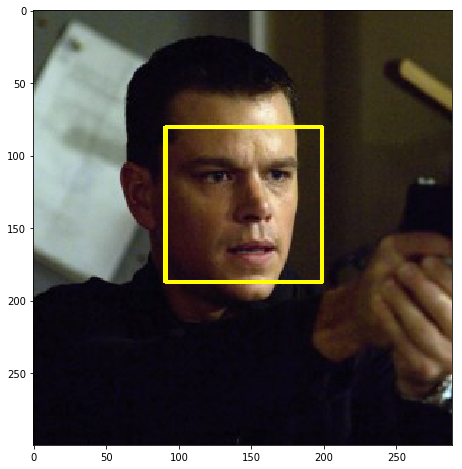

In [161]:
i = rand.randrange(0,len(clebs))
base64image = clebs.iloc[i]['Image']
img_raw = get_opencv2_image(base64image)
faces = detect_faces(img_raw)

## Dectect landmarks

In [167]:
landmarks = detect_landmarks(img_raw, faces)

RuntimeError: Unable to open /shape_predictor_68_face_landmarks.dat

# Scale And Align Images

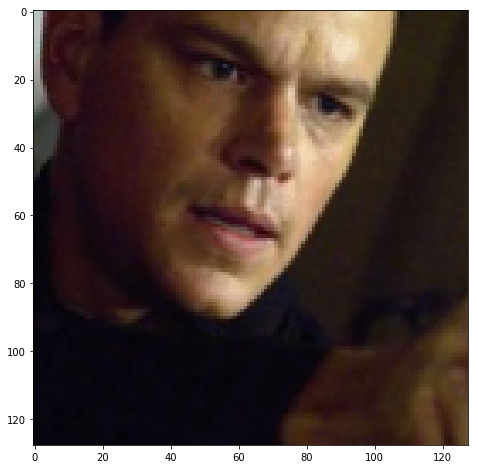

In [163]:
scaleimg = scale_face(img_raw, landmarks, display=True)

In [164]:
# Save a subset of dataset with scaled images
# n = len(clebs)
# for i in range(n):
#     print('Progess [{}/{}]'.format(i,n))
#     if rand.randint(0,10) > 4:
#         clebs.iloc[i]['Image'] = get_scaled(clebs.iloc[i]['Image'], display=False)
#     else:
#         clebs.iloc[i]['Image'] = np.nan
# clebs.dropna(inplace=True)
# np.save(path + 'scaled_subset', clebs.values)

### Create Pairs
Create x_positive pair (x,y) where x and y are the images of the same celebrity <br>
Create x_negative pair (x,y) where x and y are the images of different celebrity <br>
Label the cost for positive pairs as 0 <br>
Label the cost for negative pairs as 1


In [145]:
dataset = np.load('scaled_subset_grey.npy',allow_pickle=True)
labels = np.unique(dataset.T[:][1])
x_positive = []
x_negative = []

positive_sample_size = 0.3
negative_sample_size = 0.0005

for l in labels:
    combos_positive = list(it.combinations(dataset[np.where(dataset.T[:][1] == l)].T[0], 2))
    index = np.arange(len(combos_positive))
    np.random.shuffle(index)
    index = index[: int(len(combos_positive)*positive_sample_size)]
    x_positive += [combos_positive[j] for j in index]
    
    combos_negative = list(it.combinations(dataset[np.where(dataset.T[:][1] != l)].T[0], 2))
    index = np.arange(len(combos_negative))
    np.random.shuffle(index)
    index = index[: int(len(combos_negative)*negative_sample_size)]
    x_negative += [combos_negative[j] for j in index]


print('Positive Pairs {}'.format(len(x_positive)))
print('Negative Pairs {}'.format(len(x_negative)))
X = np.vstack((np.asarray(x_positive), np.asarray(x_negative)))
y = np.vstack((np.full((len(x_positive),1),0), np.full((len(x_negative),1),1)))
print(X.shape)
print(y.shape)
np.save(path + 'Dataset', X)
np.save(path + 'Labels', y)

Positive Pairs 11189
Negative Pairs 6747
(17936, 2, 128, 128)
(17936, 1)


### Sample of positive / negative pairs

In [ ]:
X = np.load(path + 'Dataset.npy')
y = np.load(path + 'Labels.npy')

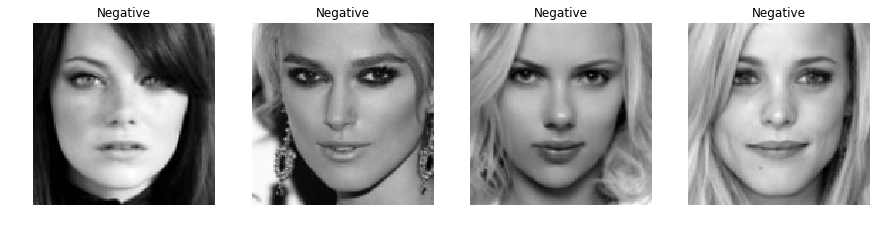

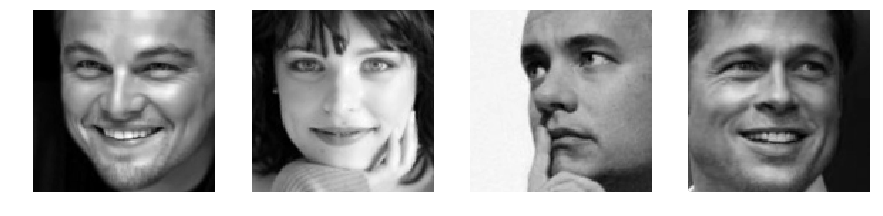

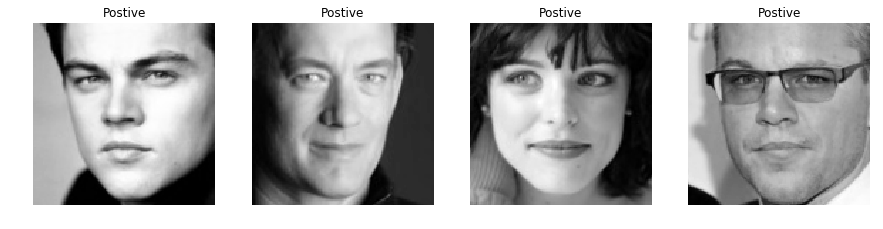

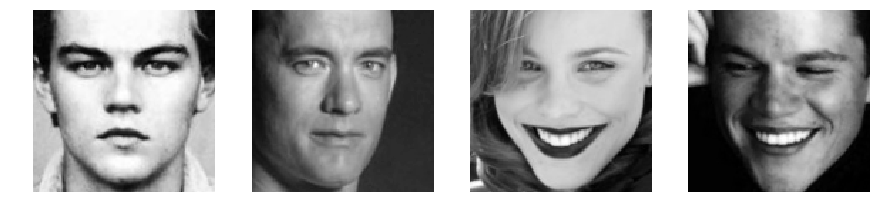

In [168]:
Xs = X[np.random.choice(np.where(y[:]==1)[0],4)]
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(Xs[i][0], cmap=plt.get_cmap('gray'))
    axarr[i].axis('off')
    axarr[i].set_title('Negative')
    
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(Xs[i][1], cmap=plt.get_cmap('gray'))
    axarr[i].axis('off')
    
Xs = X[np.random.choice(np.where(y[:]==0)[0],4)]
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(Xs[i][0], cmap=plt.get_cmap('gray'))
    axarr[i].axis('off')
    axarr[i].set_title('Postive')
    
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(Xs[i][1], cmap=plt.get_cmap('gray'))
    axarr[i].axis('off')


  ### Siamese neural network
For our model we will be using a siamese neural network where for the positive pair we will try to minimize the cost and for the negative model we will try to maximize the cost <br>
To do so we first create a CNN network to extract the 32 feature points of a point. The goal is to train this CNN such for the same celebrity the 32 feature points are similar. Only trained we use any normal vector comparision function to find the closest match. In our case we use the Eculedian distance

In [189]:
def siamese_NN(feature_count=128, image_shape=[128,128,1],verbose=True):

    img_in = Input(shape = image_dimension, name = 'FeatureNet_ImageInput')
    n_layer = img_in
    for i in range(2):
        n_layer = Conv2D(8*2**i, kernel_size = 3, activation = 'linear')(n_layer)
        n_layer = BatchNormalization()(n_layer)
        n_layer = Activation('relu')(n_layer)
        n_layer = Conv2D(16*2**i, kernel_size = 3, activation = 'linear')(n_layer)
        n_layer = BatchNormalization()(n_layer)
        n_layer = Activation('relu')(n_layer)
        n_layer = MaxPool2D((2,2))(n_layer)
    n_layer = Flatten()(n_layer)
    n_layer = Dense(feature_count, activation = 'linear')(n_layer)
    n_layer = Dropout(0.3)(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
    feature_model.summary()
    
    if verbose:
        print("Summary for Feature Generation Model : Extracting {} features".format(feature_count))
        feature_model.summary()
        print("="*100)
        print('\n\n')
   
    img_a_in = Input(shape = image_dimension, name = 'ImageA_Input')
    img_b_in = Input(shape = image_dimension, name = 'ImageB_Input')
    img_a_feat = feature_model(img_a_in)
    img_b_feat = feature_model(img_b_in)
    combined_features = concatenate(
        [img_a_feat, img_b_feat], name='merge_features')
    combined_features = Dense(
        16, activation='linear')(combined_features)
    combined_features = BatchNormalization()(combined_features)
    combined_features = Activation('relu')(combined_features)
    combined_features = Dense(4, activation='linear')(combined_features)
    combined_features = BatchNormalization()(combined_features)
    combined_features = Activation('relu')(combined_features)
    combined_features = Dense(1, activation='sigmoid')(combined_features)
    similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[
        combined_features], name='Similarity_Model')
    if verbose:
        print("Summary for Similarity Model")
        similarity_model.summary()
    similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])
    return similarity_model, feature_model

In [190]:
similarity_model, feature_model = siamese_NN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 126, 126, 8)       80        
_________________________________________________________________
batch_normalization_55 (Batc (None, 126, 126, 8)       32        
_________________________________________________________________
activation_55 (Activation)   (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 124, 124, 16)      1168      
_________________________________________________________________
batch_normalization_56 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_56 (Activation)   (None, 124, 124, 16)      0         
__________

### Split the dataset train and test 

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print('Train Shape {}'.format(X_train.shape))
print('Test Shape {}'.format(X_test.shape))
pairs = [np.reshape(X_train[:,0,:,:], [len(X_train),128,128,1]), 
         np.reshape(X_train[:,1,:,:], [len(X_train),128,128,1])]

Train Shape (12555, 2, 128, 128)
Test Shape (5381, 2, 128, 128)


# Training the model

In [194]:
# similarity_model.fit(pairs, y_train, epochs=2, verbose=1)
# similarity_model.save_weights(path + "similarity_model_d128.h10")
# feature_model.save_weights(path + "feature_model_d128.h10")

In [195]:
similarity_model.load_weights(path + 'similarity_model_g_d128.h50')
feature_model.load_weights(path+ 'feature_model_g_d128.h50')

In [198]:
def similarity_accuracy(similarity_model, X_test, y_test):
    pairs_test = [np.reshape(X_test[:,0,:,:], [len(X_test),128,128,1]), 
              np.reshape(X_test[:,1,:,:], [len(X_test),128,128,1])]
    predicted = similarity_model.predict(pairs_test, verbose=2)
    print('Accuracy')
    print(accuracy_score(y_test, np.around(predicted).astype('int')))

In [199]:
similarity_accuracy(similarity_model, X_test, y_test)

Accuracy
0.9520535216502509


# Clustering the Data

1224/1224 [==============================] - 8s 7ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1224 samples in 0.015s...
[t-SNE] Computed neighbors for 1224 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1224
[t-SNE] Computed conditional probabilities for sample 1224 / 1224
[t-SNE] Mean sigma: 1.658620
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.462391
[t-SNE] KL divergence after 1000 iterations: 0.680432


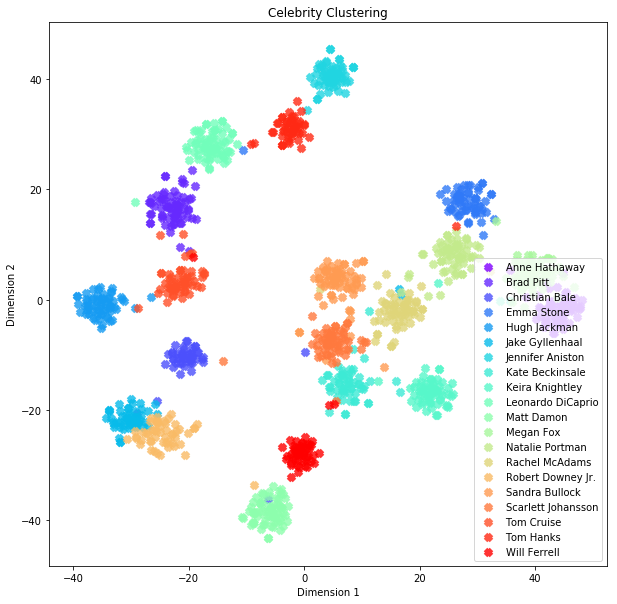

In [201]:
dataset = np.load(path + 'scaled_subset_grey.npy')

images = np.asarray([dataset[i][0] for i in range(len(dataset))])
labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
unique_labels = np.unique(labels)
images_feature = feature_model.predict(images.reshape((len(images),128,128,1)), verbose = True)

tsne = TSNE(n_components=2, init='pca', n_iter=1000, verbose=1)
tsne_features = tsne.fit_transform(images_feature)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(10, 10))
for _, (c_color, name) in enumerate(zip(colors, unique_labels)):
    plt.scatter(tsne_features[np.where(labels == name), 0],
                tsne_features[np.where(labels == name), 1],
                marker='x',
                color=c_color,
                linewidth='5',
                alpha=0.8,
                label=name)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc='best')
plt.title('Celebrity Clustering')
plt.savefig('clusterColor.png')
plt.show()

Confusion matrix, without normalization


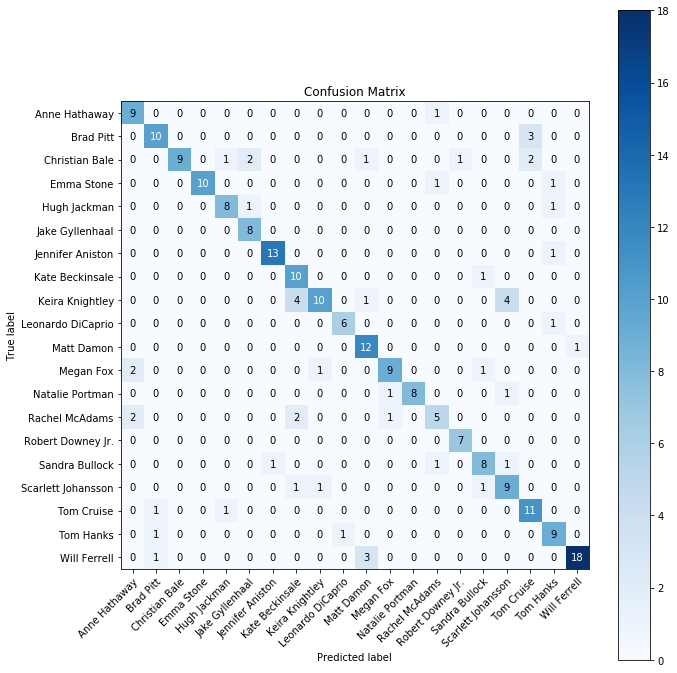

In [55]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Classification error

245/245 [==============================] - 1s 5ms/step
Accuracy
0.9428571428571428
Confusion matrix, without normalization


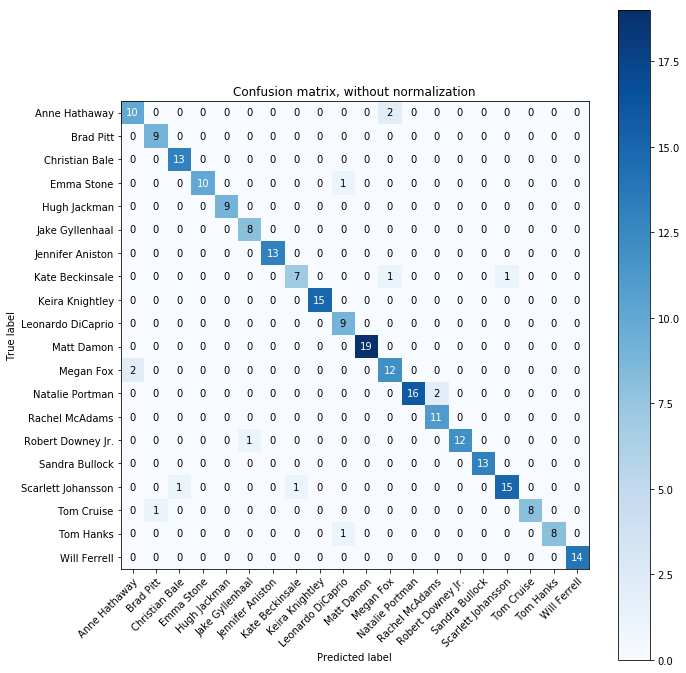

In [210]:
dataset = np.load(path + 'scaled_subset_grey.npy')

images = np.asarray([dataset[i][0] for i in range(len(dataset))])
labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
images_feature = feature_model.predict(images.reshape((len(images),128,128,1)), verbose = True)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_features = feature_model.predict(X_train.reshape((len(X_train), 128 ,128, 1)), verbose = True)
Xt_features = feature_model.predict(X_test.reshape((len(X_test), 128 ,128, 1)), verbose = True)

from sklearn.svm import NuSVC
clf = NuSVC(gamma='scale')
clf.fit(X_features, y_train)
y_predict = clf.predict(Xt_features.reshape([len(Xt_features),128]))
print('Accuracy')
print(accuracy_score(y_test, y_predict))
plot_confusion_matrix(y_test, y_predict, np.unique(labels))

In [275]:
def display_sample_prediction(labels, images, feature_model, svm_model):
    indexes = np.arange(0, len(labels))
    index = np.random.choice(indexes, 16)
    sample_images = images[index]
    y_sample_true = labels[index]
    y_sample_predict = clf.predict(feature_model.predict(sample_images.reshape(16,128,128,1)))

    fig, axarr = plt.subplots(1,8,figsize=(15,15))
    plt.axis('off')

    for i in range(8):
        axarr[i].imshow(sample_images[i], cmap=plt.get_cmap('gray'))
        axarr[i].axis('off')
        if y_sample_predict[i] != y_sample_true[i]:
            color = 'r'
        else:
            color = 'g'
        axarr[i].set_title(y_sample_predict[i], color=color)
    plt.savefig('prediction.png')

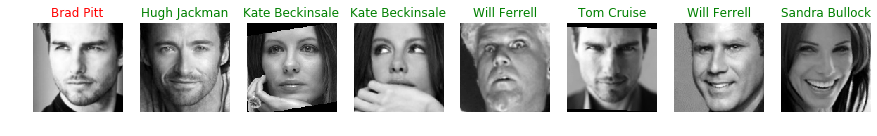

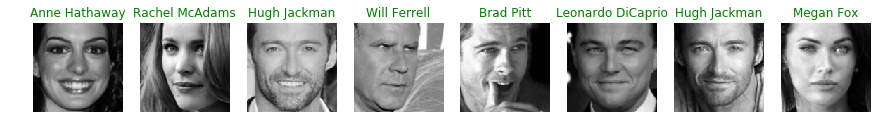

In [278]:
for i in range(2):
    display_sample_prediction(labels, images, feature_model, clf)